In [62]:
%reload_ext autoreload
%autoreload 2

In [4]:
from IPython.display import IFrame

IFrame(width=560, height=315, src="https://www.youtube.com/embed/aQJP3Z2Ho8U")

## Define the environment

In [63]:
import random
import numpy as np


class MultiArmBandit:
    def __init__(self, num_machines=None, p=None, win_reward=1., lose_reward=-1.):
        """
        Provide either p (probabilities of each slot producing a win) or
        num_machines but not both. If num_machines is provided, p is randomly
        generated
        """
        assert (num_machines is not None) ^ (p is not None)
        if num_machines is not None:
            # Probability of win for each of the machines
            self.p = np.random.uniform(0, 1, num_machines)
        else:
            self.p = p
            num_machines = len(self.p)
        # Index the action space
        self.action_space = np.arange(num_machines)
        # Expected reward for each slot - Helpful for calculating regret
        self.action_values = self.p * win_reward + (1 - self.p) * lose_reward
        # What the reward is for winning at a machine
        self.win_reward = win_reward
        # What the reward is for losing at a machine
        self.lose_reward = lose_reward

    def calculate_regret(self, action: int) -> float:
        # Best expected reward minus expected reward of selected slot
        return self.action_values.max() - self.action_values[action]

    def __len__(self):
        return len(self.p)

    def play_slot(self, action):
        assert action in range(len(self.p)), "action out of range"
        reward = self.win_reward if random.random() < self.p[action] else self.lose_reward
        return reward

## An abstract base class for an agent

In [64]:
from typing import Tuple, Dict
from abc import ABC, abstractmethod


class Agent(ABC):
    def __init__(self, env: MultiArmBandit):
        self.env = env
        # Action value estimate (Q). We'll init all to 0.
        # Note to be confused with the known action values from the environment
        self.action_values = np.zeros(len(self.env))
        # Store number of times each action was made (N)
        self.action_counts = np.zeros(len(self.env))
        # Store total number of steps
        self.time_step = 0

    @abstractmethod
    def step(self) -> Tuple[int, float]:
        """
        Should return selected action and reward
        """
        pass

    def take_action(self, selected_action: int) -> float:
        """
        Call this instead of env.play_slot as it makes sure to update tracked
        values
        """
        reward = self.env.play_slot(selected_action)
        self.action_counts[selected_action] += 1
        self.time_step += 1
        return reward

    def train(self, num_steps: int) -> Dict:
        """
        Train the agent from scratch and return some tracked quantities
        """
        actions = []
        rewards = []
        regrets = []
        action_values = []
        for _ in range(num_steps):
            action, reward = self.step()
            actions.append(action)
            rewards.append(reward)
            regrets.append(self.env.calculate_regret(action))
            action_values.append(self.action_values.copy())
        return {
            'actions': np.array(actions),
            'rewards': np.array(rewards),
            'regrets': np.array(regrets),
            'action_values': np.stack(action_values)
        }

## (Epsilon) Greedy agent

In [65]:
import numpy as np

from helpers import non_deterministic_argmax


class GreedyAgent(Agent):
    def __init__(self, env: MultiArmBandit, eps: float = 0.):
        """
        Set `eps` to make it an epsilon-greedy agent
        """
        super().__init__(env)
        assert 0 <= eps and eps <= 1, "`eps` must be a float in [0, 1]"
        self.eps = eps

    def step(self) -> Tuple[int, float]:
        # Get a probability distribution of choosing an action
        # With eps = 0 this is the purely greedy case where we select the 
        # argmax with 100% probability. Otherwise we select a random action
        # with eps probability
        argmax = non_deterministic_argmax(self.action_values)
        p_select = np.full(len(self.env), self.eps/len(self.env))
        p_select[argmax] += (1 - self.eps)
        # Select an action
        selected_action = np.random.choice(self.env.action_space, p=p_select)
        # Take the selected action
        reward = self.take_action(selected_action)
        # Update action value with simple average
        if self.action_counts[selected_action] > 0:
            # Difference between reward and estimated action value
            error = reward - self.action_values[selected_action]
            alpha = 1 / self.action_counts[selected_action]
            self.action_values[selected_action] += alpha * error
        else:
            # First time around just use the reward directly as the value
            self.action_values[selected_action] = reward
        return selected_action, reward

Below we train two variants of the epsilon-greedy agent. One is purely greedy (zero epsilon), and one has non-zero epsilon. Some observations:

- Cumulative regret looks linear.
- When the purely greedy agent gets unlucky, it's outperformed by the epsilon greedy agent.
- High epsilons cap the performance of the agent. If the purely greedy agent gets lucky, it wins out.

Slot probabilities [0.08 0.24 0.47 0.28 0.61]
Best slot: #4
Purely greedy agent last 10 slots played: [2 2 2 2 2 2 2 2 2 2]
Epsilon greedy agent last 10 slots played: [4 4 4 4 4 4 4 4 4 4]


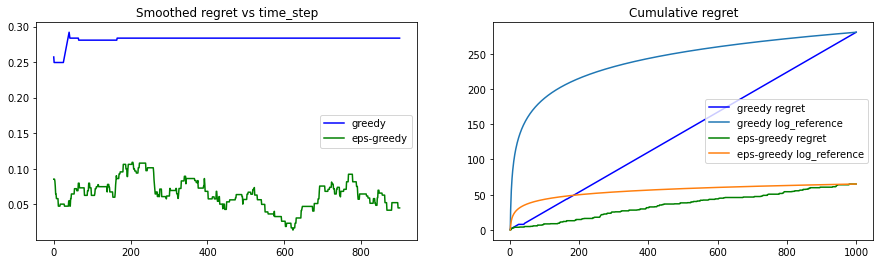

In [67]:
import matplotlib.pyplot as plt
from helpers import simple_moving_average

env = MultiArmBandit(num_machines=5, win_reward=1, lose_reward=-1)
# env = MultiArmBandit(p=np.array([0.2, 0.8]), win_reward=1, lose_reward=-1)
with np.printoptions(precision=2) as opts:
    print("Slot probabilities", env.p)
print(f"Best slot: #{env.p.argmax()}")

pure_greedy_agent = GreedyAgent(env, eps=0.)
eps_greedy_agent = GreedyAgent(env, eps=0.1)

pure_greedy_history = pure_greedy_agent.train(1_000)
eps_greedy_history = eps_greedy_agent.train(1_000)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
for name, history, color in zip(
        ["greedy", "eps-greedy"], [pure_greedy_history, eps_greedy_history], ['blue', 'green']):
    ax[0].set_title("Smoothed regret vs time_step")
    ax[0].plot(simple_moving_average(history['regrets'], 100), label=name, color=color)
    ax[0].legend()
    
    ax[1].set_title("Cumulative regret")
    cumulative_regret = np.cumsum(history['regrets'])
    x = np.arange(1, len(cumulative_regret) + 1)
    log_reference = np.log(x)
    log_reference *= cumulative_regret[-1] / log_reference[-1]
    ax[1].plot(x, cumulative_regret, label=f'{name} regret', color=color)
    ax[1].plot(x, log_reference, label=f'{name} log_reference')
    ax[1].legend()
plt.legend();

print("Purely greedy agent last 10 slots played:", pure_greedy_history['actions'][-10:])
print("Epsilon greedy agent last 10 slots played:", eps_greedy_history['actions'][-10:])

## Policy gradients

In [68]:
from helpers import softmax


class PolicyGradientAgent(Agent):
    def __init__(self, env: MultiArmBandit, lr: float, lr_decay=1., baseline: float = 0.):
        """
        Set `lr` as the learning rate (alpha in the lecture slides)
        `lr` decay mutiplies the lr each time step for learning rate annealing
        NOTE: We'll use the `action_values` as the action preferences here
        """
        super().__init__(env)
        self.lr = lr
        self.lr_decay = lr_decay
        self.baseline = baseline

    def step(self) -> Tuple[int, float]:
        # Select an action
        p = softmax(self.action_values)
        selected_action = np.random.choice(self.env.action_space, p=p)
        # Take the selected action
        reward = self.take_action(selected_action)
        # Update rule
        # For the selected action
        self.action_values[selected_action] \
            += self.lr * (reward - self.baseline) * (1 - p[selected_action])
        # For all other actions
        self.action_values[self.env.action_space != selected_action] \
            += self.lr * (reward - self.baseline) * p[self.env.action_space != selected_action]
        # Update lr
        self.lr *= self.lr_decay
        return selected_action, reward

Cumulative regret still not logarithmic

Slot probabilities [0.8 0.2 0.2]
Best slot: #0
LR will decay to: 4.5173345977048246e-06
First 10 slots played: [1 2 1 2 1 1 2 0 2 1]
Last 10 slots played: [0 0 0 0 2 0 0 0 0 0]


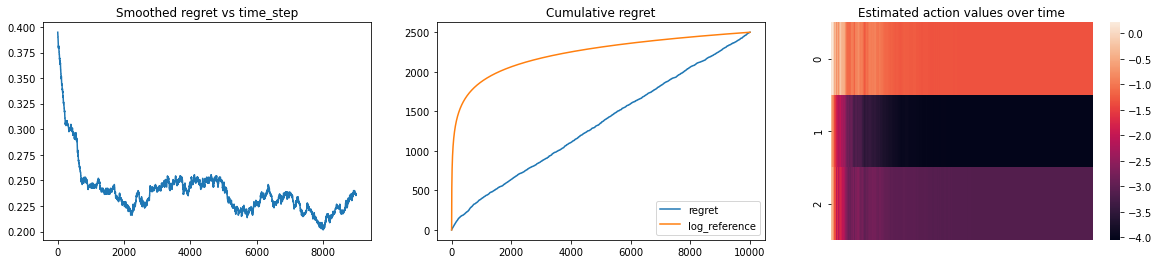

In [70]:
from helpers_lecture2 import plot_history

# env = MultiArmBandit(num_machines=5, win_reward=1., lose_reward=-1.)
env = MultiArmBandit(p=np.array([0.8, 0.2, 0.2]), win_reward=1, lose_reward=-1)
with np.printoptions(precision=2) as opts:
    print("Slot probabilities", env.p)
print(f"Best slot: #{env.p.argmax()}")

agent = PolicyGradientAgent(env, lr=.1, lr_decay=0.999, baseline=0)

num_steps = 10_000
print(f"LR will decay to: {agent.lr * agent.lr_decay**num_steps}")
history = agent.train(num_steps)

plot_history(history, smoothing=1000)

print("First 10 slots played:", history['actions'][:10])
print("Last 10 slots played:", history['actions'][-10:])

## Upper confidence bound with Lai and Robbins theorem

In [71]:
class UCBAgent(Agent):
    def __init__(self, env: MultiArmBandit, c: float = np.sqrt(1/2)):
        super().__init__(env)
        """
        c derives from what we decide p should be in Hoeffding's inequality
        So if we decide p should scale with 1/t we're saying that we want
        to tighten the upper bound over time, forcing convergence
        It turns out that p = 1/t gives c = 1 / sqrt(2).
        Larger c means we allow the algorithn to take longer to converge
        """
        self.c = c
        # Store total number of steps
        self.time_step = 0

    def step(self) -> Tuple[int, float]:
        if self.time_step == 0:
            # On first time step we don't add an upper bound offset
            selected_action = non_deterministic_argmax(self.action_values)
        else:
            # Calculate U (what we need to add to each estimated value to get
            # an optimistic upper bound)
            upper_bound_offset = self.c * np.sqrt(
                np.math.log(self.time_step) / np.maximum(self.action_counts, 1e-16))
            selected_action = non_deterministic_argmax(
                self.action_values + upper_bound_offset)
        # Take the selected action
        reward = self.take_action(selected_action)
        # Update action value with simple average
        if self.action_counts[selected_action] > 0:
            # Difference between reward and estimated action value
            error = reward - self.action_values[selected_action]
            alpha = 1 / self.action_counts[selected_action]
            self.action_values[selected_action] += alpha * error
        else:
            # First time around just use the reward directly as the value
            self.action_values[selected_action] = reward
        return selected_action, reward

Logarithmic cumulative regret!

Slot probabilities [0.57 0.08 0.36 0.98 0.13]
Best slot: #3
First 10 slots played: [1 2 3 0 4 0 3 2 3 0]
Last 10 slots played: [3 3 3 3 3 3 3 3 3 3]


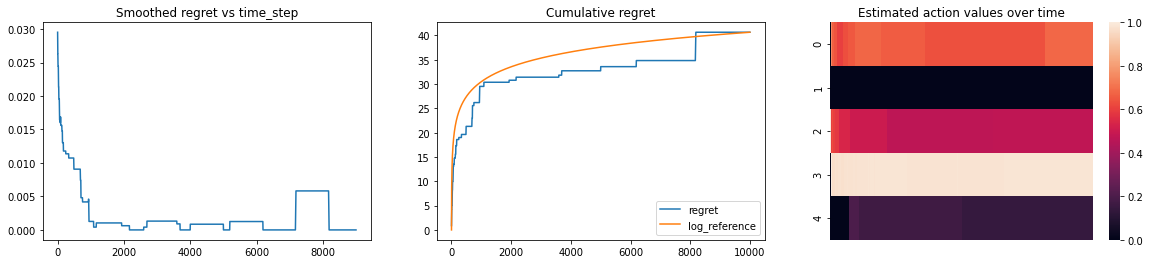

In [74]:
env = MultiArmBandit(num_machines=5, win_reward=1., lose_reward=0.)
# env = MultiArmBandit(p=np.array([0.8, 0.2, 0.2]), win_reward=1, lose_reward=-1)
with np.printoptions(precision=2) as opts:
    print("Slot probabilities", env.p)
print(f"Best slot: #{env.p.argmax()}")

agent = UCBAgent(env)

history = agent.train(10_000)

plot_history(history, smoothing=1000)

print("First 10 slots played:", history['actions'][:10])
print("Last 10 slots played:", history['actions'][-10:])

## Upper confidence bound with bayesian updates

Consider each slot to be a bernoulli random variable and start with a uniform beta distribution (alpha = 1, beta = 1) as the first prior.

In [75]:
class BayesianUCBAgent(Agent):
    def __init__(self, env: MultiArmBandit, nstd: float = 1.):
        super().__init__(env)
        # Number of standard deviations to use for the upper bound
        self.nstd = nstd
        # Array of alpha beta. 0th dim indexes the slots, 1st dim is for alpha
        # and beta
        self.alpha_beta = np.ones(shape=(len(env), 2))
        # Estimated action values are now the expected values of the beta
        # distributions
        # https://en.wikipedia.org/wiki/Beta_distribution#Mean
        self.action_values = 1 / (1 + self.alpha_beta[:, 1] / self.alpha_beta[:, 0])
    
    def step(self) -> Tuple[int, float]:
        # Calculate the upper bound the mean plus self.nstd standard deviations
        # https://en.wikipedia.org/wiki/Beta_distribution#Mean
        mean = self.action_values
        # https://en.wikipedia.org/wiki/Beta_distribution#Variance
        std = np.sqrt(self.alpha_beta.prod(1) / \
            (self.alpha_beta.sum(1)**2 * (self.alpha_beta.sum(1) + 1)))
        selected_action = non_deterministic_argmax(mean + self.nstd * std)
        # Take the selected action
        reward = self.take_action(selected_action)
        # Update the distribution for the selected action
        self.alpha_beta[selected_action] += \
            np.array([0, 1]) if reward == 0 else np.array([1, 0])
        # Update action values (for next step, and for plotting history)
        self.action_values = 1 / (1 + self.alpha_beta[:, 1] / self.alpha_beta[:, 0])
        return selected_action, reward

Slot probabilities [1.   0.1  0.47 0.42 0.71]
Best slot: #0
First 10 slots played: [3 3 3 3 2 0 0 0 0 0]
Last 10 slots played: [0 0 0 0 0 0 0 0 0 0]


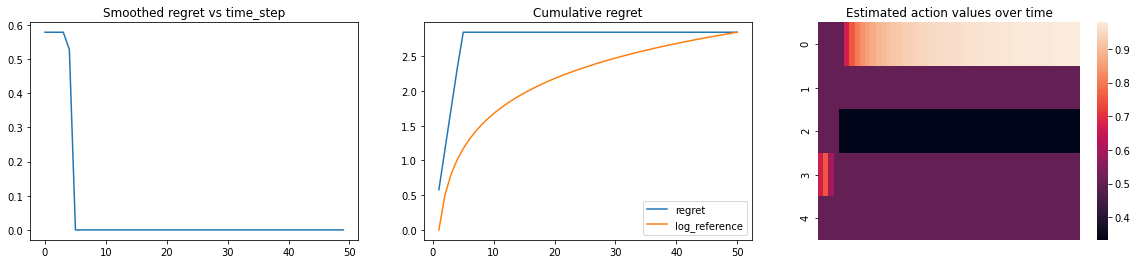

In [76]:
env = MultiArmBandit(num_machines=5, win_reward=1., lose_reward=0.)
# env = MultiArmBandit(p=np.array([0.8, 0.2, 0.2]), win_reward=1, lose_reward=-1)
with np.printoptions(precision=2) as opts:
    print("Slot probabilities", env.p)
print(f"Best slot: #{env.p.argmax()}")

agent = BayesianUCBAgent(env, nstd=1)

history = agent.train(50)

plot_history(history, smoothing=1)

print("First 10 slots played:", history['actions'][:10])
print("Last 10 slots played:", history['actions'][-10:])

## Thompson sampling

Just like UCB with bayesian but instead of upper bound argmax, do random sampling then argmax.

In [77]:
class ThompsonSamplingAgent(Agent):
    def __init__(self, env: MultiArmBandit):
        super().__init__(env)
        # Array of alpha beta. 0th dim indexes the slots, 1st dim is for alpha
        # and beta
        self.alpha_beta = np.ones(shape=(len(env), 2))
        # Estimated action values are now the expected values of the beta
        # distributions
        # https://en.wikipedia.org/wiki/Beta_distribution#Mean
        self.action_values = 1 / (1 + self.alpha_beta[:, 1] / self.alpha_beta[:, 0])
    
    def step(self) -> Tuple[int, float]:
        # Sample from each of the distributions
        samples = [np.random.beta(a, b) for a, b in self.alpha_beta] 
        # Select an action
        selected_action = np.argmax(samples)
        # Take the selected action
        reward = self.take_action(selected_action)
        # Update the distribution for the selected action
        self.alpha_beta[selected_action] += \
            np.array([0, 1]) if reward == 0 else np.array([1, 0])
        # Update action values (for plotting history)
        self.action_values = 1 / (1 + self.alpha_beta[:, 1] / self.alpha_beta[:, 0])
        return selected_action, reward

Slot probabilities [0.74 0.99 0.54 0.66 0.01]
Best slot: #1
First 10 slots played: [1 3 1 4 1 1 1 1 1 1]
Last 10 slots played: [1 1 1 1 1 1 1 1 1 1]


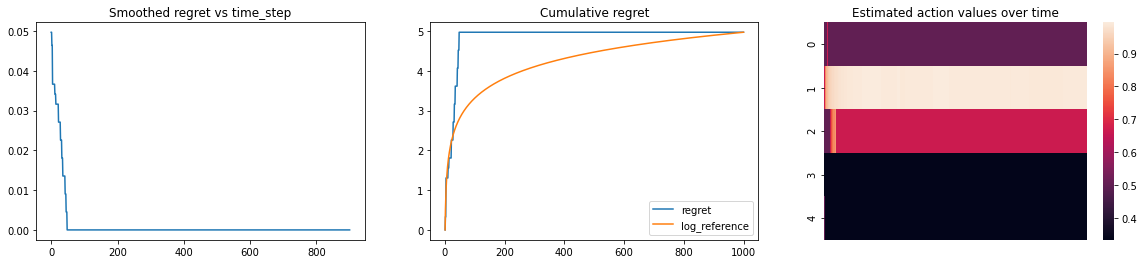

In [78]:
env = MultiArmBandit(num_machines=5, win_reward=1., lose_reward=0.)
# env = MultiArmBandit(p=np.array([0.8, 0.2, 0.2]), win_reward=1, lose_reward=-1)
with np.printoptions(precision=2) as opts:
    print("Slot probabilities", env.p)
print(f"Best slot: #{env.p.argmax()}")

agent = ThompsonSamplingAgent(env)

history = agent.train(1_000)

plot_history(history, smoothing=100)

print("First 10 slots played:", history['actions'][:10])
print("Last 10 slots played:", history['actions'][-10:])